In [116]:
import warnings
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
#Imports
import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
register_matplotlib_converters()

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from scipy import stats
from random import gauss as gs
import datetime

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

#Supress default INFO logging
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import logging, sys
warnings.simplefilter(action='ignore', category=FutureWarning)

In [117]:
df = pd.read_csv('rollingsales_manhattan.xls_prepped_bare.csv')

In [118]:
df.reset_index(drop=True)

,TAX CLASS AT PRESENT,ZIP CODE,SALE PRICE,SALE DATE
0,1,10009,2385000,2021-02-09
1,1,10009,4350000,2020-07-16
2,2B,10009,3672530,2020-11-24
3,2,10009,249508,2020-06-03
4,2B,10009,1250000,2020-06-16
...,...,...,...,...
9229,4,10033,6000000,2021-01-08
9230,4,10040,6600000,2020-12-11
9231,4,10033,12000000,2020-10-22
9232,4,10040,8000000,2020-08-20


In [119]:
df['SALE DATE']= pd.to_datetime(df['SALE DATE'])
df=df.sort_values(by='SALE DATE')

In [120]:
type(df['SALE DATE'][2])

pandas._libs.tslibs.timestamps.Timestamp

In [121]:
df_price_date = pd.DataFrame(df, columns=['SALE DATE', 'SALE PRICE'])

In [122]:
df_price_date = df_price_date.set_index('SALE DATE')

In [123]:
# df_price_date.index.unique

In [124]:
#group by day
df_price_date = df_price_date.resample('D').mean()

In [125]:
df_price_date['SALE PRICE']=df_price_date['SALE PRICE'].fillna(0)

In [126]:
df_price_date.dropna(inplace=True)

In [127]:
df_price_date.loc[(df_price_date!=0).any(1)]

,SALE PRICE
SALE DATE,
2020-04-01,2.651838e+06
2020-04-02,1.899093e+06
2020-04-03,2.315087e+06
2020-04-04,1.369242e+06
2020-04-06,7.843903e+06
...,...
2021-03-25,3.024555e+06
2021-03-26,2.232141e+06
2021-03-29,1.530709e+06


In [128]:
decomposition = seasonal_decompose(df_price_date['SALE PRICE'], model='additive', period=30)
observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [129]:
register_matplotlib_converters()

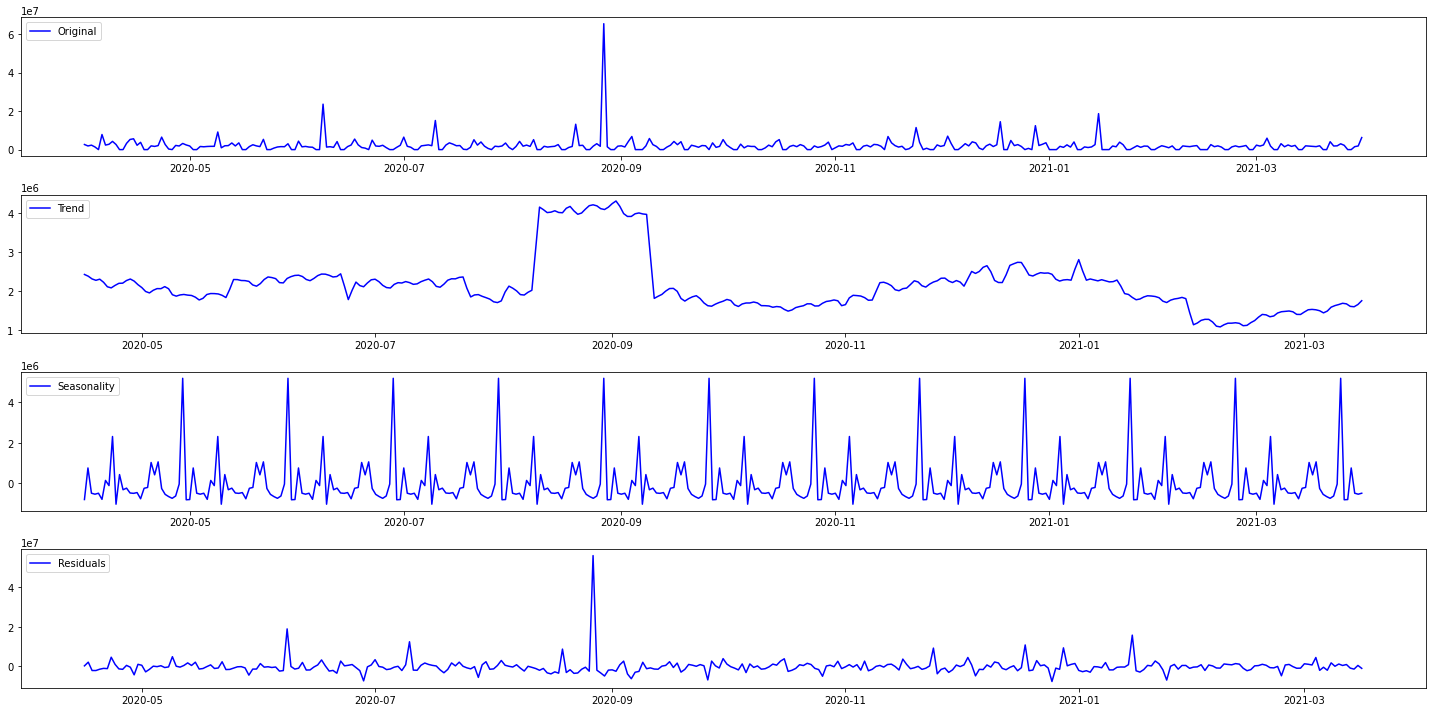

In [130]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

In [131]:
# df_price_date['roll_avg'] = df_price_date['SALE PRICE'].rolling(window=5).mean()

In [132]:
# df_price_date

In [133]:
# plt.figure(figsize=(20, 10))
# plt.scatter(df_price_date.index[:365], df_price_date['SALE PRICE'][:365], s=20)
# plt.scatter(df_price_date.index[4:365], df_price_date['roll_avg'][4:365], s=20);

In [134]:
# lr = LinearRegression()
# lr.fit(df_price_date[['roll_avg']][4:], df_price_date['SALE PRICE'][4:])

In [135]:
# plt.figure(figsize=(20, 10))
# plt.plot(df_price_date.index[:265], df_price_date['SALE PRICE'][:265], label='Data')
# plt.plot(df_price_date.index[4:265], lr.predict(df_price_date[['roll_avg']][4:265]),
#          label='Predicted')
# plt.legend();

In [136]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-5.808970891091768, 4.447417926275216e-07, 7, 357, {'1%': -3.44880082033912, '5%': -2.869670179576637, '10%': -2.5711012838861036}, 11575.736328325731)

Test Statistic                -5.808971e+00
p-value                        4.447418e-07
#Lags Used                     7.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


In [137]:
#differencing to remove seasonality period 12 rolling mean
df_price_date_diff= df_price_date.diff(periods=31)
df_price_date_diff.dropna(inplace=True)
df_price_date_diff.reset_index(drop=True)


,SALE PRICE
0,-2.651838e+06
1,-1.899093e+06
2,-6.982128e+05
3,9.997500e+04
4,1.629424e+06
...,...
329,-1.407999e+06
330,-1.705886e+06
331,-6.041941e+05
332,1.889714e+06


In [138]:
df_price_date = df_price_date - df_price_date_diff

In [139]:
df_price_date.dropna(inplace=True)

In [140]:
dftest = adfuller(df_price_date['SALE PRICE'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dftest)
print()
print(dfoutput)

(-5.546236240888791, 1.6584439809107194e-06, 7, 326, {'1%': -3.4505694423906546, '5%': -2.8704469462727795, '10%': -2.5715154495841017}, 10569.18540890266)

Test Statistic                  -5.546236
p-value                          0.000002
#Lags Used                       7.000000
Number of Observations Used    326.000000
Critical Value (1%)             -3.450569
Critical Value (5%)             -2.870447
Critical Value (10%)            -2.571515
dtype: float64


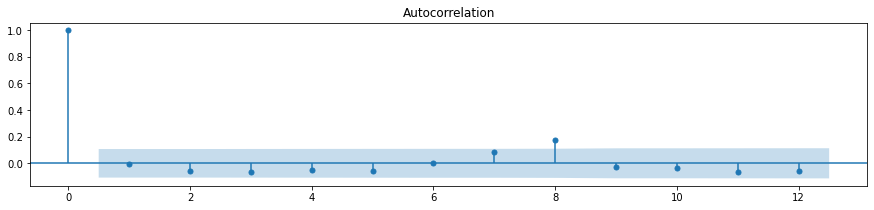

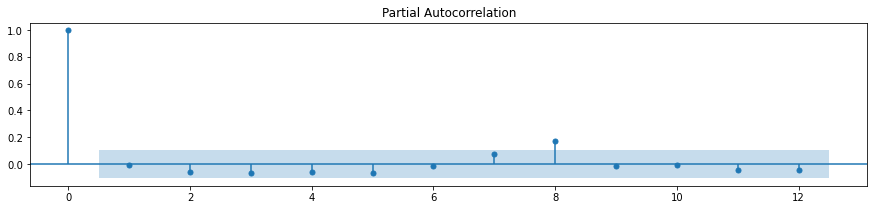

In [141]:
rcParams['figure.figsize'] = 15, 3
plot_acf(df_price_date, lags=12, alpha=0.05);

rcParams['figure.figsize'] = 15, 3
plot_pacf(df_price_date, lags=12, alpha=0.05);

In [142]:
# Instantiate & fit model with statsmodels
#p = num lags - ACF
#about 2/3 of the way between 25 and 50, 2/3 of 25 is roughly 17. Ill say 25 + 17 = 42
p = 7

 # q = lagged forecast errors - PACF
    
q = 7


# Fitting ARMA model and summary
ar = ARMA(df_price_date,(p, q)).fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             SALE PRICE   No. Observations:                  334
Model:                     ARMA(7, 7)   Log Likelihood               -5566.765
Method:                       css-mle   S.D. of innovations        4126586.634
Date:                Sat, 12 Jun 2021   AIC                          11165.530
Time:                        22:00:13   BIC                          11226.508
Sample:                    05-02-2020   HQIC                         11189.843
                         - 03-31-2021                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.191e+06   2.01e+05     10.920      0.000     1.8e+06    2.58e+06
ar.L1.SALE PRICE    -0.0491        nan        nan        nan         nan         nan
ar.L2.SALE PRICE     0.0997        nan        nan        nan         nan         nan
ar.L3.SALE PRICE    -0.1227        nan        nan        nan         nan         nan
ar.L4.SALE PRICE     0.1208        nan        nan        nan         nan         nan
ar.L5.SALE PRICE    -0.1019        nan        nan        nan         nan         nan
ar.L6.SALE PRICE     0.0476        nan        nan        nan         nan         nan
ar.L7.SALE PRICE     0.9986        nan        nan        nan         nan         nan
ma.L1.SALE PRICE     0.0500        nan        nan        nan         nan         nan
ma.L2.SALE PRICE    -0.1054        nan        nan        nan         nan         nan
ma.L3.SALE PRICE     0.1206        nan        nan        nan         nan         nan
ma.L4.SALE PRICE    -0.1206        nan        nan        nan         nan         nan
ma.L5.SALE PRICE     0.1054        nan        nan        nan         nan         nan
ma.L6.SALE PRICE    -0.0501        nan        nan        nan         nan         nan
ma.L7.SALE PRICE    -1.0000        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0010           -0.0000j            1.0010           -0.0000
AR.2            0.6252           -0.7805j            1.0000           -0.1425
AR.3            0.6252           +0.7805j            1.0000            0.1425
AR.4           -0.2214           -0.9752j            1.0000           -0.2855
AR.5           -0.2214           +0.9752j            1.0000            0.2855
AR.6           -0.9281           -0.3726j            1.0001           -0.4392
AR.7           -0.9281           +0.3726j            1.0001            0.4392
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.6260           -0.7799j            1.0000           -0.1424
MA.3            0.6260           +0.7799j            1.0000            0.1424
MA.4           -0.2226           -0.9749j            1.0000           -0.2857
MA.5           -0.2226           +0.9749j            1.0000            0.2857
MA.6           -0.9284           -0.3716j            1.0000           -0.4394
MA.7           -0.9284           +0.3716j            1.0000            0.4394
-----------------------------------------------------------------------------
"""

In [143]:
r2_score(df_price_date, ar.predict())

0.06292410966655271

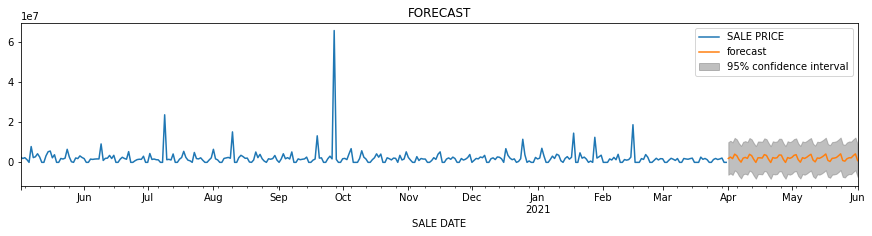

In [144]:
#plot of ARMA model
fig, ax = plt.subplots()
ax = df_price_date.plot(ax=ax, title='FORECAST')
fig = ar.plot_predict('2021-04-01', '2021-06-01', dynamic=True, ax=ax, plot_insample=False)
plt.show()